In [1477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import metrics
import holidays

In [1496]:
df = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [1497]:
df.head()
# G: 발전용, E: 주택/업무난방, A: 산업용, B: 일반용, D: , H: , C: 냉난방공조용

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [1498]:
df['연월일'] = pd.to_datetime(df['연월일'])

In [1499]:
df['year'] = df['연월일'].dt.year
df['month'] = df['연월일'].dt.month
df['day'] = df['연월일'].dt.day
df['weekday'] = df['연월일'].dt.weekday
df['weekofyear'] = df['연월일'].dt.weekofyear

In [1500]:
df['supply'] = df['공급량']
df['hour'] = df['시간']
df['type'] = df['구분']

In [1501]:
# 한국 휴일 객체 생성 
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['date','holiday'])
holiday_df['date'] = df['연월일']
holiday_df['holiday'] = holiday_df.date.apply(lambda x: 1 if x in kr_holidays else 0)
df['holiday'] = holiday_df['holiday']
df

,연월일,시간,구분,공급량,year,month,day,weekday,weekofyear,supply,hour,type,holiday
0,2013-01-01,1,A,2497.129,2013,1,1,1,1,2497.129,1,A,1
1,2013-01-01,2,A,2363.265,2013,1,1,1,1,2363.265,2,A,1
2,2013-01-01,3,A,2258.505,2013,1,1,1,1,2258.505,3,A,1
3,2013-01-01,4,A,2243.969,2013,1,1,1,1,2243.969,4,A,1
4,2013-01-01,5,A,2344.105,2013,1,1,1,1,2344.105,5,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,2018,12,31,0,1,681.033,20,H,0
368084,2018-12-31,21,H,669.961,2018,12,31,0,1,669.961,21,H,0
368085,2018-12-31,22,H,657.941,2018,12,31,0,1,657.941,22,H,0
368086,2018-12-31,23,H,610.953,2018,12,31,0,1,610.953,23,H,0


In [1504]:
df = df.drop(['연월일', '시간', '구분', '공급량'], axis=1)

KeyError: "['연월일' '시간' '구분' '공급량'] not found in axis"

In [1505]:
df

,year,month,day,weekday,weekofyear,supply,hour,type,holiday
0,2013,1,1,1,1,2497.129,1,A,1
1,2013,1,1,1,1,2363.265,2,A,1
2,2013,1,1,1,1,2258.505,3,A,1
3,2013,1,1,1,1,2243.969,4,A,1
4,2013,1,1,1,1,2344.105,5,A,1
...,...,...,...,...,...,...,...,...,...
368083,2018,12,31,0,1,681.033,20,H,0
368084,2018,12,31,0,1,669.961,21,H,0
368085,2018,12,31,0,1,657.941,22,H,0
368086,2018,12,31,0,1,610.953,23,H,0


In [1506]:
w_df = pd.read_csv('weather/SURFACE_ASOS_108_HR_2013_2013_2018.csv', encoding='cp949')
w_df.columns

Index(['지점', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',
       '운형(운형약어)', '최저운고(100m )', '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)',
       '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)'],
      dtype='object')

In [1507]:
path = os.listdir(path='weather/')
path.remove('.DS_Store')
w_dff = pd.DataFrame()

for _ in path:
    w_df = pd.read_csv('weather/'+_, encoding='cp949')
    w_dff = pd.concat([w_dff, w_df])

In [1508]:
w_df = w_dff[['지점', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '적설(cm)']]
w_df

,지점,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
0,159,2015-01-01 00:00,0.2,NaN,3.8,38.0,NaN
1,159,2015-01-01 01:00,-0.5,NaN,3.2,42.0,NaN
2,159,2015-01-01 02:00,-0.8,NaN,6.8,43.0,NaN
3,159,2015-01-01 03:00,-1.5,NaN,4.1,43.0,NaN
4,159,2015-01-01 04:00,-2.1,NaN,5.9,43.0,NaN
...,...,...,...,...,...,...,...
8755,159,2014-12-31 19:00,2.4,NaN,2.7,43.0,NaN
8756,159,2014-12-31 20:00,1.8,NaN,4.4,40.0,NaN
8757,159,2014-12-31 21:00,1.7,NaN,5.1,40.0,NaN
8758,159,2014-12-31 22:00,1.4,NaN,7.5,36.0,NaN


In [1509]:
w_df.columns = ['loc', 'date', 'degree', 'rain', 'wind', 'humi', 'snow']
w_df['date'] = pd.to_datetime(w_df['date'])
w_df

,loc,date,degree,rain,wind,humi,snow
0,159,2015-01-01 00:00:00,0.2,NaN,3.8,38.0,NaN
1,159,2015-01-01 01:00:00,-0.5,NaN,3.2,42.0,NaN
2,159,2015-01-01 02:00:00,-0.8,NaN,6.8,43.0,NaN
3,159,2015-01-01 03:00:00,-1.5,NaN,4.1,43.0,NaN
4,159,2015-01-01 04:00:00,-2.1,NaN,5.9,43.0,NaN
...,...,...,...,...,...,...,...
8755,159,2014-12-31 19:00:00,2.4,NaN,2.7,43.0,NaN
8756,159,2014-12-31 20:00:00,1.8,NaN,4.4,40.0,NaN
8757,159,2014-12-31 21:00:00,1.7,NaN,5.1,40.0,NaN
8758,159,2014-12-31 22:00:00,1.4,NaN,7.5,36.0,NaN


In [1510]:
w_df = w_df.fillna(0)

In [1511]:
w_daily_df = w_df.groupby(['date'])['degree', 'rain', 'wind', 'humi', 'snow'].mean()
# 날짜 기준으로 서울과 부산의 산술평균치 계산

In [1512]:
w_daily_df

,degree,rain,wind,humi,snow
date,,,,,
2013-01-01 00:00:00,-5.30,0.0,2.60,53.5,3.2
2013-01-01 01:00:00,-5.45,0.0,2.90,55.5,3.2
2013-01-01 02:00:00,-5.45,0.0,2.95,56.5,3.2
2013-01-01 03:00:00,-5.05,0.0,2.55,55.0,3.2
2013-01-01 04:00:00,-5.25,0.0,2.95,56.0,3.2
...,...,...,...,...,...
2018-12-31 19:00:00,0.95,0.0,3.30,38.5,0.0
2018-12-31 20:00:00,0.70,0.0,2.25,36.0,0.0
2018-12-31 21:00:00,0.00,0.0,2.05,38.5,0.0


In [1513]:
w_daily_df = w_daily_df.reset_index()

In [1514]:
w_daily_df['year'] = w_daily_df['date'].dt.year
w_daily_df['month'] = w_daily_df['date'].dt.month
w_daily_df['day'] = w_daily_df['date'].dt.day
w_daily_df['weekday'] = w_daily_df['date'].dt.weekday
w_daily_df['hour'] = w_daily_df['date'].dt.hour+1
w_daily_df['weekofyear'] = w_daily_df['date'].dt.weekofyear
del w_daily_df['date']
w_daily_df

,degree,rain,wind,humi,snow,year,month,day,weekday,hour,weekofyear
0,-5.30,0.0,2.60,53.5,3.2,2013,1,1,1,1,1
1,-5.45,0.0,2.90,55.5,3.2,2013,1,1,1,2,1
2,-5.45,0.0,2.95,56.5,3.2,2013,1,1,1,3,1
3,-5.05,0.0,2.55,55.0,3.2,2013,1,1,1,4,1
4,-5.25,0.0,2.95,56.0,3.2,2013,1,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...
52579,0.95,0.0,3.30,38.5,0.0,2018,12,31,0,20,1
52580,0.70,0.0,2.25,36.0,0.0,2018,12,31,0,21,1
52581,0.00,0.0,2.05,38.5,0.0,2018,12,31,0,22,1
52582,-0.80,0.0,3.40,36.0,0.0,2018,12,31,0,23,1


In [1515]:
df_w = pd.merge(df, w_daily_df, on=['year', 'month', 'day', 'weekday', 'hour', 'weekofyear'])
df_w.head(10)

,year,month,day,weekday,weekofyear,supply,hour,type,holiday,degree,rain,wind,humi,snow
0,2013,1,1,1,1,2497.129,1,A,1,-5.30,0.0,2.6,53.5,3.2
1,2013,1,1,1,1,2169.093,1,B,1,-5.30,0.0,2.6,53.5,3.2
2,2013,1,1,1,1,226.178,1,C,1,-5.30,0.0,2.6,53.5,3.2
3,2013,1,1,1,1,1434.516,1,D,1,-5.30,0.0,2.6,53.5,3.2
4,2013,1,1,1,1,3272.837,1,E,1,-5.30,0.0,2.6,53.5,3.2
5,2013,1,1,1,1,3560.365,1,G,1,-5.30,0.0,2.6,53.5,3.2
6,2013,1,1,1,1,562.964,1,H,1,-5.30,0.0,2.6,53.5,3.2
7,2013,1,1,1,1,2363.265,2,A,1,-5.45,0.0,2.9,55.5,3.2
8,2013,1,1,1,1,2051.733,2,B,1,-5.45,0.0,2.9,55.5,3.2
9,2013,1,1,1,1,215.778,2,C,1,-5.45,0.0,2.9,55.5,3.2


In [1416]:
from itertools import permutations
type_list = ['A', 'B', 'C', 'D', 'E', 'H', 'G']
type_permu = list(permutations(type_list, 7))
len(type_permu)

5040

In [204]:
# A: 산업용, B: 일반용, C: 냉난방공조용, D: 기타(열전용설비용), E: 주택/업무난방, G: 발전용, H: 수송용
def price_match(price_df, year=0, month=0, price=[]):
    winter = [1, 2, 3, 12]
    summer = [6, 7, 8, 9]

    for i in range(len(price_df)):
        if price_df.iloc[i, 0] == year:
            if price_df.iloc[i, 1] == month:
                break
        if price_df.iloc[i, 3] == None:
            if price_df.iloc[i, 2] == 'E':
                price_df.iloc[i, 3] = (price[0]+price[1])/2
            elif price_df.iloc[i, 2] == 'D':
                price_df.iloc[i, 3] = price[14]
            elif price_df.iloc[i, 2] == 'H':
                price_df.iloc[i, 3] = price[15]

            elif price_df.iloc[i, 1] in winter: ## 동절기
                if price_df.iloc[i, 2] == 'A':
                    price_df.iloc[i, 3] = price[8]
                elif price_df.iloc[i, 2] == 'B':
                    price_df.iloc[i, 3] = price[2]
                elif price_df.iloc[i, 2] == 'C':
                    price_df.iloc[i, 3] = price[5]
                elif price_df.iloc[i, 2] == 'G':
                    price_df.iloc[i, 3] = price[11]

            elif price_df.iloc[i, 1] in summer: ## 하절기
                if price_df.iloc[i, 2] == 'A':
                    price_df.iloc[i, 3] = price[9]
                elif price_df.iloc[i, 2] == 'B':
                    price_df.iloc[i, 3] = price[3]
                elif price_df.iloc[i, 2] == 'C':
                    price_df.iloc[i, 3] = price[6]
                elif price_df.iloc[i, 2] == 'G':
                    price_df.iloc[i, 3] = price[12]

            elif price_df.iloc[i, 1] == 5:
                if price_df.iloc[i, 2] == 'C':
                    price_df.iloc[i, 3] = price[6]

            if price_df.iloc[i, 3] == None:
                if price_df.iloc[i, 2] == 'A':
                    price_df.iloc[i, 3] = price[10]
                elif price_df.iloc[i, 2] == 'B':
                    price_df.iloc[i, 3] = price[4]
                elif price_df.iloc[i, 2] == 'C':
                    price_df.iloc[i, 3] = price[7]
                elif price_df.iloc[i, 2] == 'G':
                    price_df.iloc[i, 3] = price[13]

    return price_df

In [1008]:
def average_price(price_df, year=0, month=0, price=[]):
    winter = [1, 2, 3, 12]
    summer = [6, 7, 8, 9]
    normal = [4, 5, 10, 11]
    
    for i in range(len(price_df)):
        if price_df.iloc[i, 0] == year:
            if price_df.iloc[i, 1] == month:
                break
        if price_df.iloc[i, 3] == None:
            if price_df.iloc[i, 1] in normal: 
                price_df.iloc[i, 3] = (price[0]+price[1]+price[14]+price[15]+price[4]+price[10]+price[7]+price[13])/8
            elif price_df.iloc[i, 1] in winter: # 동절기
                price_df.iloc[i, 3] = (price[0]+price[1]+price[14]+price[15]+price[8]+price[2]+price[5]+price[11])/8
            elif price_df.iloc[i, 1] in summer:
                price_df.iloc[i, 3] = (price[0]+price[1]+price[14]+price[15]+price[9]+price[3]+price[6]+price[12])/8

    return price_df

In [1005]:
price_df = pd.DataFrame(columns=['year', 'month', 'type', 'price'])
year = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
typee = ['A', 'B', 'C', 'D', 'E', 'G', 'H']

for y in year:
    for m in month:
        for t in typee:
            add_df = pd.DataFrame({'year': [y],
                                  'month': [m],
                                  'type': [t]})
            price_df = pd.concat([price_df, add_df])
price_df['price'] = None

In [1006]:
price_df

,year,month,type,price
0,2013,1,A,None
0,2013,1,B,None
0,2013,1,C,None
0,2013,1,D,None
0,2013,1,E,None
...,...,...,...,...
0,2019,12,C,None
0,2019,12,D,None
0,2019,12,E,None
0,2019,12,G,None


In [300]:
price_201601 = pd.read_csv('도시가스용 용도별 도매요금표_160101.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201601 = list(map(float, price_201601))
price_201603 = pd.read_csv('도시가스용 용도별 도매요금표_160301.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201603 = list(map(float, price_201603))
price_201605 = pd.read_csv('도시가스용 용도별 도매요금표_160501.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201605 = list(map(float, price_201605))
price_201611 = pd.read_csv('도시가스용 용도별 도매요금표_161101.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201611 = list(map(float, price_201611))

price_201701 = pd.read_csv('도시가스용 용도별 도매요금표_170101.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201701 = list(map(float, price_201701))
price_201703 = pd.read_csv('도시가스용 용도별 도매요금표_170301.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201703 = list(map(float, price_201703))
price_201705 = pd.read_csv('도시가스용 용도별 도매요금표_170501.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201705 = list(map(float, price_201705))
price_201711 = pd.read_csv('도시가스용 용도별 도매요금표_171101.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201711 = list(map(float, price_201711))

price_201805 = pd.read_csv('도시가스용 용도별 도매요금표_180501.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201805 = list(map(float, price_201805))
price_201807 = pd.read_csv('도시가스용 용도별 도매요금표_180701.csv', encoding='cp949').iloc[:, 2].dropna().tolist()[2:]
price_201807 = list(map(float, price_201807))

In [301]:
# price_2013 = price_match(price_df=price_df, year=2013, month=3, price=[19.0344, 19.5637, 18.7647, 18.5651, 18.5651, 19.5153, 12.2073, 18.6412, 18.5981, 18.0653, 18.0653, (19.2508+19.2860)/2, (18.2592+18.2723)/2, (18.2592+182723)/2, 20.05, 18.2072])
# price_2013_2 = price_match(price_df=price_2013, year=2013, month=8, price=[19.8910, 20.4203, 19.6213, 19.4217, 19.4217, 20.3719, 12.8498, 19.4978, 19.4547, 18.9219, 18.9219, (20.1074+20.1426)/2, (19.1158+19.1289)/2, (19.1158+19.1289)/2, 20.9066, 19.0638])

# price_2014 = price_match(price_df=price_2013_2, year=2014, month=1, price=[20.1143, 20.4868, 19.6655, 19.4635, 19.4911, 20.3651, 12.8498, 19.8666, 19.4154, 18.9121, 18.9636, 19.9884, 19.0591, 19.1668, 21.1202, 19.0549])
# price_2014_2 = price_match(price_df=price_2014, year=2014, month=7, price=[21.3150, 21.6875, 20.8662, 20.6642, 20.6918, 21.5658, 13.7503, 21.0673, 20.6161, 20.1128, 20.1643, 21.1891, 20.2598, 20.3675, 22.3209, 20.2556])

# price_2015 = price_match(price_df=price_2014_2, year=2015, month=1, price=[21.0905, 21.463, 20.6417, 20.4397, 20.4673, 21.3413, 13.5035, 20.8428, 20.3916, 19.8883, 19.9398, 20.9646, 20.0353, 20.1430, 22.0964, 20.0311])
# price_2015_2 = price_match(price_df=price_2015, year=2015, month=3, price=[19.8134, 20.1859, 19.3646, 19.1626, 19.1902, 20.0632, 12.5456, 19.5657, 19.1145, 18.6112, 18.6627, 19.6875, 18.7582, 18.8659, 20.8193, 18.7540])
# price_2015_3 = price_match(price_df=price_2015_2, year=2015, month=5, price=[17.9866, 17.8975, 17.0762, 16.8742, 16.9018, 17.7758, 10.8014, 17.2773, 16.8261, 16.3228, 16.3743, 17.3991, 16.4698, 16.5775, 18.5309, 16.4656])
# price_2015_4 = price_match(price_df=price_2015_3, year=2015, month=9, price=[16.3771, 16.6148, 15.0998, 14.8448, 14.8540, 16.1268, 8.7752, 15.0623, 14.9638, 14.206, 14.2289, 15.5624, 14.3429, 14.3906, 17.2097, 14.4412])

# price_2016 = price_match(price_df=price_2015_4, year=2016, month=1, price=[17.0962, 17.3339, 15.8189, 15.5639, 15.5731, 16.8459, 9.3146, 15.7814, 15.6829, 14.9251, 14.9480, 16.2815, 15.0620, 15.0997, 17.9288, 15.1603])
# price_2016_2 = price_match(price_df=price_2016, year=2016, month=3, price=price_201601)
# price_2016_3 = price_match(price_df=price_2016_2, year=2016, month=5, price=price_201601)
# price_2016_4 = price_match(price_df=price_2016_3, year=2016, month=11, price=price_201605)

# price_2017 = price_match(price_df=price_2016_4, year=2017, month=1, price=price_201611)
# price_2017_2 = price_match(price_df=price_2017, year=2017, month=3, price=price_201701)
# price_2017_3 = price_match(price_df=price_2017_2, year=2017, month=5, price=price_201703)
# price_2017_4 = price_match(price_df=price_2017_3, year=2017, month=11, price=price_201705)

# price_2018 = price_match(price_df=price_2017_4, year=2018, month=5, price=price_201711)
# price_2018_2 = price_match(price_df=price_2018, year=2018, month=7, price=price_201805)
# price_2018_3 = price_match(price_df=price_2018_2, year=2020, month=1, price=price_201807)


In [1009]:
price_2013 = average_price(price_df=price_df, year=2013, month=3, price=[19.0344, 19.5637, 18.7647, 18.5651, 18.5651, 19.5153, 12.2073, 18.6412, 18.5981, 18.0653, 18.0653, (19.2508+19.2860)/2, (18.2592+18.2723)/2, (18.2592+182723)/2, 20.05, 18.2072])
price_2013_2 = average_price(price_df=price_2013, year=2013, month=8, price=[19.8910, 20.4203, 19.6213, 19.4217, 19.4217, 20.3719, 12.8498, 19.4978, 19.4547, 18.9219, 18.9219, (20.1074+20.1426)/2, (19.1158+19.1289)/2, (19.1158+19.1289)/2, 20.9066, 19.0638])

price_2014 = average_price(price_df=price_2013_2, year=2014, month=1, price=[20.1143, 20.4868, 19.6655, 19.4635, 19.4911, 20.3651, 12.8498, 19.8666, 19.4154, 18.9121, 18.9636, 19.9884, 19.0591, 19.1668, 21.1202, 19.0549])
price_2014_2 = average_price(price_df=price_2014, year=2014, month=7, price=[21.3150, 21.6875, 20.8662, 20.6642, 20.6918, 21.5658, 13.7503, 21.0673, 20.6161, 20.1128, 20.1643, 21.1891, 20.2598, 20.3675, 22.3209, 20.2556])

price_2015 = average_price(price_df=price_2014_2, year=2015, month=1, price=[21.0905, 21.463, 20.6417, 20.4397, 20.4673, 21.3413, 13.5035, 20.8428, 20.3916, 19.8883, 19.9398, 20.9646, 20.0353, 20.1430, 22.0964, 20.0311])
price_2015_2 = average_price(price_df=price_2015, year=2015, month=3, price=[19.8134, 20.1859, 19.3646, 19.1626, 19.1902, 20.0632, 12.5456, 19.5657, 19.1145, 18.6112, 18.6627, 19.6875, 18.7582, 18.8659, 20.8193, 18.7540])
price_2015_3 = average_price(price_df=price_2015_2, year=2015, month=5, price=[17.9866, 17.8975, 17.0762, 16.8742, 16.9018, 17.7758, 10.8014, 17.2773, 16.8261, 16.3228, 16.3743, 17.3991, 16.4698, 16.5775, 18.5309, 16.4656])
price_2015_4 = average_price(price_df=price_2015_3, year=2015, month=9, price=[16.3771, 16.6148, 15.0998, 14.8448, 14.8540, 16.1268, 8.7752, 15.0623, 14.9638, 14.206, 14.2289, 15.5624, 14.3429, 14.3906, 17.2097, 14.4412])

price_2016 = average_price(price_df=price_2015_4, year=2016, month=1, price=[17.0962, 17.3339, 15.8189, 15.5639, 15.5731, 16.8459, 9.3146, 15.7814, 15.6829, 14.9251, 14.9480, 16.2815, 15.0620, 15.0997, 17.9288, 15.1603])
price_2016_2 = average_price(price_df=price_2016, year=2016, month=3, price=price_201601)
price_2016_3 = average_price(price_df=price_2016_2, year=2016, month=5, price=price_201601)
price_2016_4 = average_price(price_df=price_2016_3, year=2016, month=11, price=price_201605)

price_2017 = average_price(price_df=price_2016_4, year=2017, month=1, price=price_201611)
price_2017_2 = average_price(price_df=price_2017, year=2017, month=3, price=price_201701)
price_2017_3 = average_price(price_df=price_2017_2, year=2017, month=5, price=price_201703)
price_2017_4 = average_price(price_df=price_2017_3, year=2017, month=11, price=price_201705)

price_2018 = average_price(price_df=price_2017_4, year=2018, month=5, price=price_201711)
price_2018_2 = average_price(price_df=price_2018, year=2018, month=7, price=price_201805)
price_2018_3 = average_price(price_df=price_2018_2, year=2020, month=1, price=price_201807)


In [1011]:
price_2018_3.to_csv('ave_price2013_2018.csv')

In [302]:
price_2018_3.to_csv('price2013_2018.csv')

In [1012]:
price_df = price_2018_3
price_df

,year,month,type,price
0,2013,1,A,19.125225
0,2013,1,B,19.125225
0,2013,1,C,19.125225
0,2013,1,D,19.125225
0,2013,1,E,19.125225
...,...,...,...,...
0,2019,12,C,13.669025
0,2019,12,D,13.669025
0,2019,12,E,13.669025
0,2019,12,G,13.669025


In [ ]:
pd.pivot_table(df_w, values='supply', index=['type', 'hour', 'weekday'], aggfunc=np.mean).reset_index()
df_w.apply(lambda x: supply_mean.loc[(supply_mean.type == x['type']) & (supply_mean.hour == x['hour']) & (supply_mean.weekday == x['weekday']), 'supply'].values[0], axis=1)

pd.pivot_table(df_w, values='supply', index=['type', 'hour'], aggfunc=np.mean).reset_index()
df_w.apply(lambda x: supply_mean.loc[(supply_mean.type == x['type']) & (supply_mean.hour == x['hour']), 'supply'].vaules[0], axis=1)


In [1516]:
supply_mean = pd.pivot_table(df_w, values='supply', index=['type', 'hour', 'weekday'], aggfunc=np.mean).reset_index()
df_w['type_weekday_hour_mean'] = df_w.apply(lambda x: supply_mean.loc[(supply_mean.type == x['type']) & (supply_mean.hour == x['hour']) & (supply_mean.weekday == x['weekday']) ,'supply'].values[0], axis=1)

supply_hour_mean = pd.pivot_table(df_w, values='supply', index=['type', 'hour'], aggfunc=np.mean).reset_index()
df_w['type_hour_mean'] = df_w.apply(lambda x: supply_hour_mean.loc[(supply_hour_mean.type == x['type']) & (supply_hour_mean.hour == x['hour']) ,'supply'].values[0], axis=1)

supply_hour_std = pd.pivot_table(df_w, values='supply', index=['type', 'hour'], aggfunc=np.std).reset_index()
df_w['type_hour_std'] = df_w.apply(lambda x: supply_hour_std.loc[(supply_hour_std.type == x['type']) & (supply_hour_std.hour == x['hour']) ,'supply'].values[0], axis=1)

In [1014]:
merge_df = pd.merge(df_w, price_df, on=['year', 'month', 'type'])

In [1015]:
data = merge_df

In [1016]:
data

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
0,2013,1,1,1,2497.129,1,A,-5.30,0.0,2.60,53.5,3.2,19.125225
1,2013,1,1,1,2363.265,2,A,-5.45,0.0,2.90,55.5,3.2,19.125225
2,2013,1,1,1,2258.505,3,A,-5.45,0.0,2.95,56.5,3.2,19.125225
3,2013,1,1,1,2243.969,4,A,-5.05,0.0,2.55,55.0,3.2,19.125225
4,2013,1,1,1,2344.105,5,A,-5.25,0.0,2.95,56.0,3.2,19.125225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018,12,31,0,681.033,20,H,0.95,0.0,3.30,38.5,0.0,13.669025
368084,2018,12,31,0,669.961,21,H,0.70,0.0,2.25,36.0,0.0,13.669025
368085,2018,12,31,0,657.941,22,H,0.00,0.0,2.05,38.5,0.0,13.669025
368086,2018,12,31,0,610.953,23,H,-0.80,0.0,3.40,36.0,0.0,13.669025


In [1017]:
data.describe()

,day,weekday,supply,hour,degree,rain,wind,humi,snow
count,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.00000
mean,15.726609,3.000000,948.100037,12.500000,14.251352,0.145357,2.787936,61.344137,0.08545
std,8.798824,2.000003,927.211578,6.922196,9.853273,0.912700,1.287493,17.783476,0.54779
min,1.000000,0.000000,1.378000,1.000000,-13.900000,0.000000,0.000000,0.000000,0.00000
25%,8.000000,1.000000,221.973000,6.750000,6.050000,0.000000,1.900000,48.000000,0.00000
50%,16.000000,3.000000,637.014000,12.500000,15.300000,0.000000,2.650000,62.000000,0.00000
75%,23.000000,5.000000,1398.919000,18.250000,22.600000,0.000000,3.500000,75.000000,0.00000
max,31.000000,6.000000,11593.617000,24.000000,36.500000,39.650000,12.000000,100.000000,8.25000


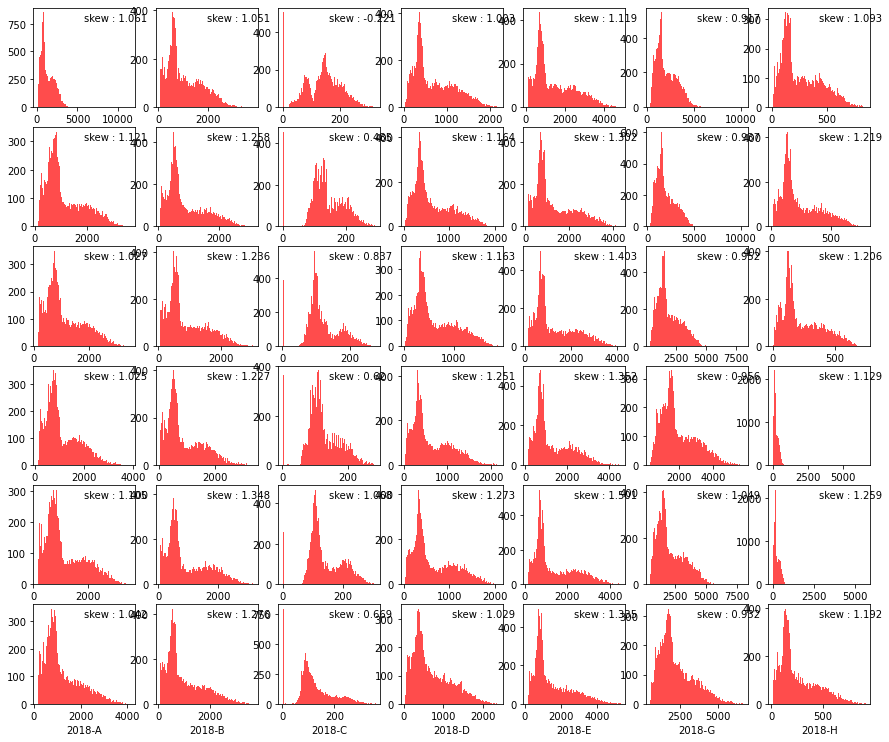

In [1018]:
fig = plt.figure(figsize = (15,15))
year_list = data['year'].unique().tolist()
type_list = data['type'].unique().tolist()
i = 1
for y in year_list:
    for t in type_list:
        ax = plt.subplot(7, 7, i)
        supply = data[(data['year'] == y) & (data['type'] == t)]['supply'].values
        mean = supply.mean().round(3)
        std = supply.std().round(3)
        skew = (3*(mean - np.median(supply))/supply.std()).round(3)
        i += 1
        
        plt.hist(supply, alpha = 0.7, bins = 100, color = 'red')
        plt.xlabel('{}-{}'.format(y, t))
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

A type 2013 이상치, C type 0부근에 이상치, G type도 최대값에 이상치, H type 2016, 2017에 이상치

In [1026]:
# A 2013년도 이상치 확인
data[(data['type'] == 'A') & (data['supply'] > 5000)]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
15190,2013,4,3,2,11593.617,23,A,10.05,0.0,3.25,54.0,0.0,19.655681


In [1034]:
data.iloc[15187:15192]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
15187,2013,4,3,2,1671.945,20,A,11.75,0.0,5.15,44.0,0.0,19.655681
15188,2013,4,3,2,1655.537,21,A,10.65,0.0,5.60,50.5,0.0,19.655681
15189,2013,4,3,2,1673.345,22,A,10.20,0.0,4.55,52.5,0.0,19.655681
15190,2013,4,3,2,1580.477,23,A,10.05,0.0,3.25,54.0,0.0,19.655681
15191,2013,4,3,2,1487.609,24,A,9.90,0.0,1.35,55.0,0.0,19.655681


In [1033]:
data.iloc[15190, 4] = (data.iloc[15189]['supply'] + data.iloc[15191]['supply']) / 2
# 앞뒤 평균값으로 조정

In [1042]:
# C 이상치 조정
data[(data['type'] == 'C') & (data['supply'] < 3)]['supply'].unique()

array([1.378, 2.978, 2.178, 2.756])

In [1049]:
data_c = data[data['type'] == 'C']
data_c[data_c['supply'].isin([1.378, 2.756])]
# 1.378 and 2.756이 이상치로 추측

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
37383,2013,8,12,0,1.378,16,C,31.00,0.0,4.00,58.0,0.0,18.882587
37384,2013,8,12,0,1.378,17,C,31.25,0.0,4.00,55.0,0.0,18.882587
37385,2013,8,12,0,1.378,18,C,30.85,0.0,3.95,56.0,0.0,18.882587
37386,2013,8,12,0,1.378,19,C,30.15,0.0,2.90,59.0,0.0,18.882587
37387,2013,8,12,0,1.378,20,C,29.05,0.0,3.00,64.5,0.0,18.882587
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354370,2018,10,11,3,2.756,11,C,11.25,0.0,1.70,44.0,0.0,13.334762
354371,2018,10,11,3,2.756,12,C,13.40,0.0,3.50,37.0,0.0,13.334762
354372,2018,10,11,3,2.756,13,C,15.10,0.0,3.05,33.0,0.0,13.334762
354373,2018,10,11,3,2.756,14,C,15.05,0.0,5.00,33.5,0.0,13.334762


In [1050]:
# 이상치가 일정 기간에 연속적으로 분포되어 있으므로 주어진 데이터에서 같은 월일의 평균값으로 조정하기로 함
c_idx = data_c[data_c['supply'] == 1.378].index

for i in c_idx:
    filters = data[(data['month'] == data_c.loc[i, 'month']) & (data['day'] == data_c.loc[i, 'day']) & (data['hour'] == data_c.loc[i, 'hour']) & (data['type'] == 'C')]
    data.loc[i, 'supply'] = (filters['supply'].sum()-1.378)/(len(filters)-1)
    
c_idx2 = data_c[data_c['supply'] == 2.756].index

for i in c_idx2:
    filters = data[(data['month'] == data_c.loc[i, 'month']) & (data['day'] == data_c.loc[i, 'day']) & (data['hour'] == data_c.loc[i, 'hour']) & (data['type'] == 'C')]
    data.loc[i, 'supply'] = (filters['supply'].sum()-2.756)/(len(filters)-1)

In [1052]:
data[(data['type'] == 'C') & (data['supply'] < 3)]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
78374,2014,4,21,0,2.978,15,C,20.10,0.0,4.30,46.0,0.0,20.983738
144951,2015,5,28,3,2.978,16,C,28.30,0.0,4.25,28.5,0.0,15.397325
221473,2016,8,11,3,2.978,2,C,27.60,0.0,1.40,77.0,0.0,11.542
221474,2016,8,11,3,2.978,3,C,27.35,0.0,0.65,79.0,0.0,11.542
221475,2016,8,11,3,2.178,4,C,27.15,0.0,1.15,79.0,0.0,11.542
221476,2016,8,11,3,2.178,5,C,26.80,0.0,1.10,79.5,0.0,11.542
221477,2016,8,11,3,2.978,6,C,26.70,0.0,1.05,80.5,0.0,11.542
272963,2017,6,30,4,2.178,12,C,27.10,0.0,3.50,65.5,0.0,13.203488


In [1053]:
# G 이상치 조정
data[data['supply'] > 8000]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
4367,2013,1,27,6,10207.077,24,G,-4.70,0.0,1.60,43.0,0.0,19.125225
116327,2014,11,14,4,10271.437,24,G,6.00,0.0,2.65,54.0,0.0,20.759238
177805,2015,11,21,5,8086.693,14,G,15.50,0.0,1.65,54.0,0.0,16.115175
254161,2017,2,7,1,8005.709,2,G,-1.15,0.0,1.55,46.0,0.0,13.580925


In [1055]:
data.iloc[4365:4370]
data.iloc[4367, 4] = (data.iloc[4366]['supply'] + data.iloc[4368]['supply']) / 2

In [1057]:
data.iloc[116325:116330]
data.iloc[116327, 4] = (data.iloc[116326]['supply'] + data.iloc[116328]['supply']) / 2

In [1059]:
data.iloc[177803:177807]
data.iloc[177805, 4] = (data.iloc[177804]['supply'] + data.iloc[177806]['supply']) / 2

In [1061]:
data.iloc[254160:254163]
data.iloc[254161, 4] = (data.iloc[254160]['supply'] + data.iloc[254162]['supply']) / 2

In [1062]:
data[data['supply'] > 8000]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price


In [1064]:
data_h = data[data['type'] == 'H']
data_h[data_h['supply'] > 1500]

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
188976,2016,1,24,6,3227.524,1,H,-12.20,0.00,3.35,42.5,0.0,14.96955
188977,2016,1,24,6,6644.788,2,H,-12.40,0.00,3.55,43.5,0.0,14.96955
203836,2016,4,12,1,1557.836,5,H,9.35,0.00,2.40,58.5,0.0,14.566175
285731,2017,8,9,2,2620.516,12,H,27.65,0.15,1.65,74.5,0.0,13.203488
285732,2017,8,9,2,5676.964,13,H,27.80,0.35,1.80,71.0,0.0,13.203488


In [1086]:
data.iloc[188973:188980]
data.iloc[188976:188978]['supply'] = (data.iloc[188975]['supply'] + data.iloc[188978]['supply'])/2

/var/folders/jq/1n7m0hfj3x57l85ms7j9xwn40000gn/T/ipykernel_56390/4138441095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[188976:188978]['supply'] = (data.iloc[188975]['supply'] + data.iloc[188978]['supply'])/2


In [1089]:
data.iloc[203833:203839]
data.iloc[203836:203838]['supply'] = (data.iloc[203835]['supply'] + data.iloc[203838]['supply'])/2

/var/folders/jq/1n7m0hfj3x57l85ms7j9xwn40000gn/T/ipykernel_56390/3696854374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[203836:203838]['supply'] = (data.iloc[203835]['supply'] + data.iloc[203838]['supply'])/2


In [1091]:
data.iloc[285728:285734]
data.iloc[285731:285733]['supply'] = (data.iloc[285730]['supply'] + data.iloc[285733]['supply'])/2

/var/folders/jq/1n7m0hfj3x57l85ms7j9xwn40000gn/T/ipykernel_56390/1270294778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.iloc[285731:285733]['supply'] = (data.iloc[285730]['supply'] + data.iloc[285733]['supply'])/2


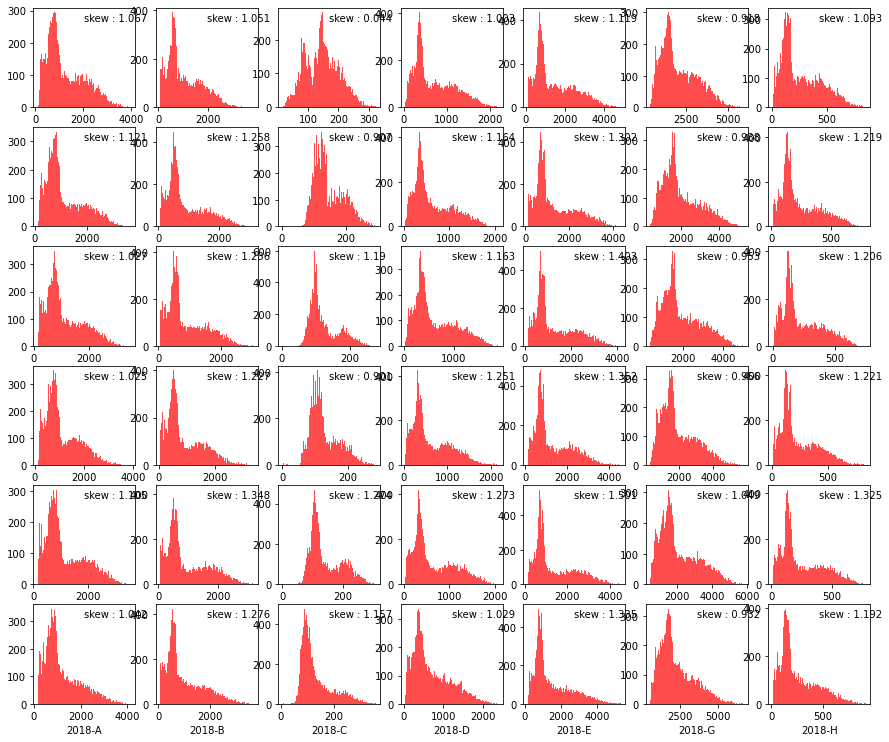

In [1092]:
fig = plt.figure(figsize = (15,15))
year_list = data['year'].unique().tolist()
type_list = data['type'].unique().tolist()
i = 1
for y in year_list:
    for t in type_list:
        ax = plt.subplot(7, 7, i)
        supply = data[(data['year'] == y) & (data['type'] == t)]['supply'].values
        mean = supply.mean().round(3)
        std = supply.std().round(3)
        skew = (3*(mean - np.median(supply))/supply.std()).round(3)
        i += 1
        
        plt.hist(supply, alpha = 0.7, bins = 100, color = 'red')
        plt.xlabel('{}-{}'.format(y, t))
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [1093]:
data.describe()

,day,weekday,supply,hour,degree,rain,wind,humi,snow
count,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.000000,368088.00000
mean,15.726609,3.000000,948.705639,12.500000,14.251352,0.145357,2.787936,61.344137,0.08545
std,8.798824,2.000003,925.876912,6.922196,9.853273,0.912700,1.287493,17.783476,0.54779
min,1.000000,0.000000,2.178000,1.000000,-13.900000,0.000000,0.000000,0.000000,0.00000
25%,8.000000,1.000000,221.955250,6.750000,6.050000,0.000000,1.900000,48.000000,0.00000
50%,16.000000,3.000000,637.013000,12.500000,15.300000,0.000000,2.650000,62.000000,0.00000
75%,23.000000,5.000000,1398.808000,18.250000,22.600000,0.000000,3.500000,75.000000,0.00000
max,31.000000,6.000000,6641.641000,24.000000,36.500000,39.650000,12.000000,100.000000,8.25000


In [1094]:
data_fix = data

In [1097]:
data_fix['supply'] = np.log1p(data_fix['supply'])

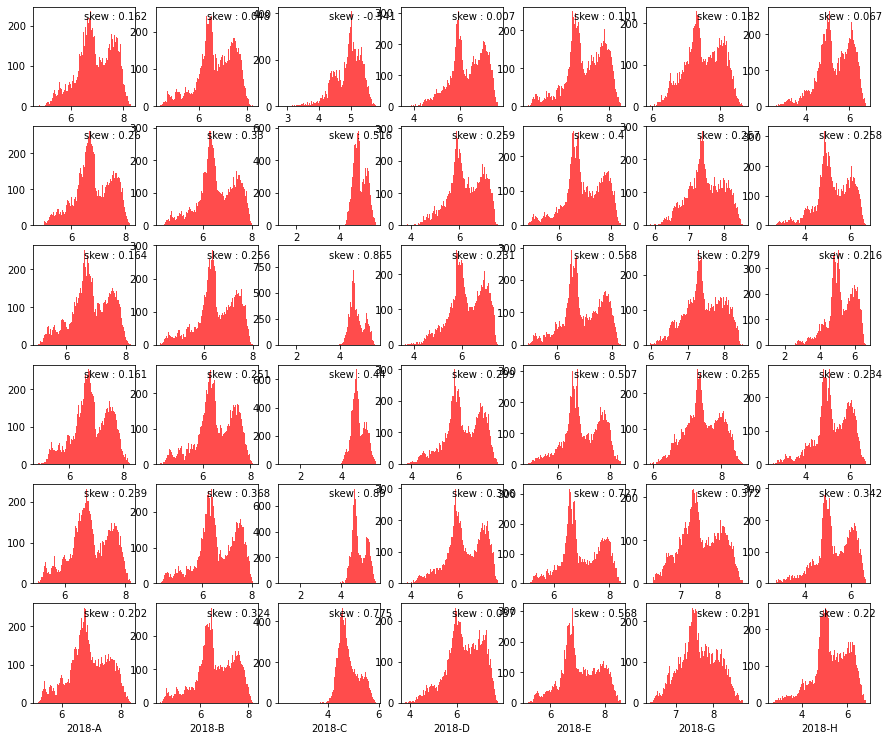

In [1098]:
fig = plt.figure(figsize = (15,15))
year_list = data_fix['year'].unique().tolist()
type_list = data_fix['type'].unique().tolist()
i = 1
for y in year_list:
    for t in type_list:
        ax = plt.subplot(7, 7, i)
        supply = data_fix[(data_fix['year'] == y) & (data_fix['type'] == t)]['supply'].values
        mean = supply.mean().round(3)
        std = supply.std().round(3)
        skew = (3*(mean - np.median(supply))/supply.std()).round(3)
        i += 1
        
        plt.hist(supply, alpha = 0.7, bins = 100, color = 'red')
        plt.xlabel('{}-{}'.format(y, t))
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [1100]:
data_fix.to_csv('prepro_data_log.csv')

In [1101]:
data.to_csv('prepro_data.csv')

In [1526]:
data_fix['weekofyear'] = df_w['weekofyear']
data_fix['type_weekday_hour_mean'] = df_w['type_weekday_hour_mean']
data_fix['type_hour_mean'] = df_w['type_hour_mean']
data_fix['type_hour_std'] = df_w['type_hour_std']

In [1527]:
data_fix

,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2013,1,1,1,7.823297,1,0,-5.30,0.0,2.60,53.5,3.2,1,985.318879,972.988785,682.513856
1,2013,1,1,1,7.768222,2,0,-5.45,0.0,2.90,55.5,3.2,1,826.542511,827.306492,631.545563
2,2013,1,1,1,7.722901,3,0,-5.45,0.0,2.95,56.5,3.2,1,127.971623,126.667231,57.256654
3,2013,1,1,1,7.716447,4,0,-5.05,0.0,2.55,55.0,3.2,1,565.299914,563.890240,408.425654
4,2013,1,1,1,7.760085,5,0,-5.25,0.0,2.95,56.0,3.2,1,1247.119744,1248.292302,924.700886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018,12,31,0,6.525078,20,6,0.95,0.0,3.30,38.5,0.0,1,137.662326,135.291645,62.046292
368084,2018,12,31,0,6.508711,21,6,0.70,0.0,2.25,36.0,0.0,1,647.859597,639.394313,454.212530
368085,2018,12,31,0,6.490634,22,6,0.00,0.0,2.05,38.5,0.0,1,1457.744182,1437.471740,1028.190810
368086,2018,12,31,0,6.416655,23,6,-0.80,0.0,3.40,36.0,0.0,1,2125.874099,2045.629131,1112.799033


In [1129]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
data_fix['type'] = class_le.fit_transform(data_fix['type'].astype(str))
data_fix

,index,year,month,day,weekday,supply,hour,type,degree,rain,wind,humi,snow,price
0,0,2013,1,1,1,7.823297,1,0,-5.30,0.0,2.60,53.5,3.2,19.125225
1,1,2013,1,1,1,7.768222,2,0,-5.45,0.0,2.90,55.5,3.2,19.125225
2,2,2013,1,1,1,7.722901,3,0,-5.45,0.0,2.95,56.5,3.2,19.125225
3,3,2013,1,1,1,7.716447,4,0,-5.05,0.0,2.55,55.0,3.2,19.125225
4,4,2013,1,1,1,7.760085,5,0,-5.25,0.0,2.95,56.0,3.2,19.125225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,368083,2018,12,31,0,6.525078,20,6,0.95,0.0,3.30,38.5,0.0,13.669025
368084,368084,2018,12,31,0,6.508711,21,6,0.70,0.0,2.25,36.0,0.0,13.669025
368085,368085,2018,12,31,0,6.490634,22,6,0.00,0.0,2.05,38.5,0.0,13.669025
368086,368086,2018,12,31,0,6.416655,23,6,-0.80,0.0,3.40,36.0,0.0,13.669025


In [1528]:
data_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   year                    368088 non-null  int64  
 1   month                   368088 non-null  int64  
 2   day                     368088 non-null  int64  
 3   weekday                 368088 non-null  int64  
 4   supply                  368088 non-null  float64
 5   hour                    368088 non-null  int64  
 6   type                    368088 non-null  int64  
 7   degree                  368088 non-null  float64
 8   rain                    368088 non-null  float64
 9   wind                    368088 non-null  float64
 10  humi                    368088 non-null  float64
 11  snow                    368088 non-null  float64
 12  weekofyear              368088 non-null  int64  
 13  type_weekday_hour_mean  368088 non-null  float64
 14  type_hour_mean      

In [1122]:
data_fix['year'] = data_fix['year'].astype(np.int64)
data_fix['month'] = data_fix['month'].astype(np.int64)
data_fix['type'] = data_fix['type'].astype(str)
data_fix['price'] = data_fix['price'].astype(np.float64)

In [1131]:
# data_fix = data_fix.reset_index()
data_fix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   index    368088 non-null  int64  
 1   year     368088 non-null  int64  
 2   month    368088 non-null  int64  
 3   day      368088 non-null  int64  
 4   weekday  368088 non-null  int64  
 5   supply   368088 non-null  float64
 6   hour     368088 non-null  int64  
 7   type     368088 non-null  int64  
 8   degree   368088 non-null  float64
 9   rain     368088 non-null  float64
 10  wind     368088 non-null  float64
 11  humi     368088 non-null  float64
 12  snow     368088 non-null  float64
 13  price    368088 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 39.3 MB


In [1529]:
labels = data_fix['supply']
train = data_fix.drop(['supply'], axis=1)

In [1530]:
train.head(10)

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2013,1,1,1,1,0,-5.30,0.0,2.60,53.5,3.20,1,985.318879,972.988785,682.513856
1,2013,1,1,1,2,0,-5.45,0.0,2.90,55.5,3.20,1,826.542511,827.306492,631.545563
2,2013,1,1,1,3,0,-5.45,0.0,2.95,56.5,3.20,1,127.971623,126.667231,57.256654
3,2013,1,1,1,4,0,-5.05,0.0,2.55,55.0,3.20,1,565.299914,563.890240,408.425654
4,2013,1,1,1,5,0,-5.25,0.0,2.95,56.0,3.20,1,1247.119744,1248.292302,924.700886
5,2013,1,1,1,6,0,-5.35,0.0,2.40,58.0,3.20,1,1849.089188,1790.720322,973.940706
6,2013,1,1,1,7,0,-5.65,0.1,2.50,68.5,3.45,1,217.027681,219.133800,171.760353
7,2013,1,1,1,8,0,-5.45,0.0,2.30,71.0,4.00,1,820.722869,814.675537,621.358365
8,2013,1,1,1,9,0,-5.15,0.0,2.35,69.0,4.60,1,657.362681,663.995602,568.704207
9,2013,1,1,1,10,0,-2.95,0.6,1.95,63.0,4.60,1,116.200048,115.149864,53.517238


In [ ]:
def nmae(true, pred):
    return np.mean((np.abs(true-pred))/true)

In [1241]:
from sklearn.metrics import mean_squared_error
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.06, 0.1],
        'max_depth': [7, 8, 9],
        'min_child_weight': [1],
        'subsample': [0.5, 0.6, 0.7],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'n_estimators' : [100, 110, 120],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [1242]:
hyperParameterTuning(train, labels)cross_val_score

Fitting 5 folds for each of 162 candidates, totalling 810 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 120,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [ ]:
xgb_model = XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.7,
        learning_rate=0.1,
        max_depth=8,
        min_child_weight=1,
        n_estimators=120,
        subsample=0.7)

In [1318]:
def nmae2(true, pred):
    return np.mean((np.abs(true-pred))/true)

In [741]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [1597]:
sample = pd.read_csv('sample_submission.csv')
sample

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0
...,...,...
15115,2019-03-31 20 H,0
15116,2019-03-31 21 H,0
15117,2019-03-31 22 H,0
15118,2019-03-31 23 H,0


In [1605]:
sample['일자'] = sample['일자|시간|구분'].str.split(' ').str[0]
sample['시간'] = sample['일자|시간|구분'].str.split(' ').str[1].astype(int)
sample['구분'] = sample['일자|시간|구분'].str.split(' ').str[2]

In [1606]:
sample['일자'] = pd.to_datetime(sample['일자'])
sample['year'] = sample['일자'].dt.year
sample['month'] = sample['일자'].dt.month
sample['day'] = sample['일자'].dt.day
sample['weekday'] = sample['일자'].dt.weekday
sample['weekofyear'] = sample['일자'].dt.weekofyear
sample['hour'] = sample['시간']
sample['type'] = sample['구분']
sample

,일자|시간|구분,공급량,일자,시간,구분,year,month,day,weekday,weekofyear,hour,type
0,2019-01-01 01 A,0,2019-01-01,1,A,2019,1,1,1,1,1,A
1,2019-01-01 02 A,0,2019-01-01,2,A,2019,1,1,1,1,2,A
2,2019-01-01 03 A,0,2019-01-01,3,A,2019,1,1,1,1,3,A
3,2019-01-01 04 A,0,2019-01-01,4,A,2019,1,1,1,1,4,A
4,2019-01-01 05 A,0,2019-01-01,5,A,2019,1,1,1,1,5,A
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,0,2019-03-31,20,H,2019,3,31,6,13,20,H
15116,2019-03-31 21 H,0,2019-03-31,21,H,2019,3,31,6,13,21,H
15117,2019-03-31 22 H,0,2019-03-31,22,H,2019,3,31,6,13,22,H
15118,2019-03-31 23 H,0,2019-03-31,23,H,2019,3,31,6,13,23,H


In [1607]:
sample_set = sample[['일자|시간|구분', 'year', 'month', 'day', 'weekday', 'hour', 'type']]

In [1608]:
sample_w = pd.merge(sample_set, average_w_df, on=['month', 'day', 'hour'])
sample_w['weekofyear'] = sample['일자'].dt.weekofyear

In [1609]:
sample_w['type_weekday_hour_mean'] = sample_w.apply(lambda x: supply_mean.loc[(supply_mean.type == x['type']) & (supply_mean.hour == x['hour']) & (supply_mean.weekday == x['weekday']) ,'supply'].values[0], axis=1)

sample_w['type_hour_mean'] = sample_w.apply(lambda x: supply_hour_mean.loc[(supply_hour_mean.type == x['type']) & (supply_hour_mean.hour == x['hour']) ,'supply'].values[0], axis=1)

sample_w['type_hour_std'] = sample_w.apply(lambda x: supply_hour_std.loc[(supply_hour_std.type == x['type']) & (supply_hour_std.hour == x['hour']) ,'supply'].values[0], axis=1)

In [1182]:
average_w_df = w_daily_df.groupby(['month', 'day', 'hour'])['degree', 'rain', 'wind', 'humi', 'snow'].mean()

/var/folders/jq/1n7m0hfj3x57l85ms7j9xwn40000gn/T/ipykernel_56390/1544450884.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_w_df = w_daily_df.groupby(['month', 'day', 'hour'])['degree', 'rain', 'wind', 'humi', 'snow'].mean()


In [1184]:
average_w_df = average_w_df.reset_index()
average_w_df

,month,day,hour,degree,rain,wind,humi,snow
0,1,1,1,-0.366667,0.0,3.141667,54.250000,0.533333
1,1,1,2,-0.683333,0.0,3.183333,54.916667,0.533333
2,1,1,3,-0.966667,0.0,3.283333,56.250000,0.533333
3,1,1,4,-1.200000,0.0,2.458333,56.083333,0.533333
4,1,1,5,-1.550000,0.0,2.941667,58.083333,0.533333
...,...,...,...,...,...,...,...,...
8779,12,31,20,2.783333,0.0,3.383333,49.250000,0.000000
8780,12,31,21,2.283333,0.0,3.133333,49.916667,0.000000
8781,12,31,22,1.775000,0.0,3.150000,51.000000,0.000000
8782,12,31,23,1.166667,0.0,3.775000,50.666667,0.000000


In [1610]:
sample_w

,일자|시간|구분,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2019-01-01 01 A,2019,1,1,1,1,A,-0.366667,0.0,3.141667,54.25,0.533333,1,985.318879,972.988785,682.513856
1,2019-01-01 01 B,2019,1,1,1,1,B,-0.366667,0.0,3.141667,54.25,0.533333,1,826.542511,827.306492,631.545563
2,2019-01-01 01 C,2019,1,1,1,1,C,-0.366667,0.0,3.141667,54.25,0.533333,1,127.971623,126.667231,57.256654
3,2019-01-01 01 D,2019,1,1,1,1,D,-0.366667,0.0,3.141667,54.25,0.533333,1,565.299914,563.890240,408.425654
4,2019-01-01 01 E,2019,1,1,1,1,E,-0.366667,0.0,3.141667,54.25,0.533333,1,1247.119744,1248.292302,924.700886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 24 C,2019,3,31,6,24,C,10.908333,0.0,1.925000,66.00,0.000000,13,126.983530,135.291645,62.046292
15116,2019-03-31 24 D,2019,3,31,6,24,D,10.908333,0.0,1.925000,66.00,0.000000,13,577.159307,639.394313,454.212530
15117,2019-03-31 24 E,2019,3,31,6,24,E,10.908333,0.0,1.925000,66.00,0.000000,13,1328.925153,1437.471740,1028.190810
15118,2019-03-31 24 G,2019,3,31,6,24,G,10.908333,0.0,1.925000,66.00,0.000000,13,1745.768358,2045.629131,1112.799033


In [1187]:
price_2019 = price_2018_3[price_2018_3['year'] == 2019]
price_2019

,year,month,type,price
0,2019,1,A,13.669025
0,2019,1,B,13.669025
0,2019,1,C,13.669025
0,2019,1,D,13.669025
0,2019,1,E,13.669025
...,...,...,...,...
0,2019,12,C,13.669025
0,2019,12,D,13.669025
0,2019,12,E,13.669025
0,2019,12,G,13.669025


In [1188]:
sample_w_p = pd.merge(sample_w, price_2019, on=['year', 'month', 'type'])

In [1189]:
sample_w_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     15120 non-null  object 
 1   month    15120 non-null  object 
 2   day      15120 non-null  int64  
 3   weekday  15120 non-null  int64  
 4   hour     15120 non-null  int64  
 5   type     15120 non-null  object 
 6   degree   15120 non-null  float64
 7   rain     15120 non-null  float64
 8   wind     15120 non-null  float64
 9   humi     15120 non-null  float64
 10  snow     15120 non-null  float64
 11  price    15120 non-null  object 
dtypes: float64(5), int64(3), object(4)
memory usage: 1.5+ MB


In [1190]:
sample_w_p['year'] = sample_w_p['year'].astype(np.int64)
sample_w_p['month'] = sample_w_p['month'].astype(np.int64)
sample_w_p['price'] = sample_w_p['price'].astype(np.float64)
sample_w_p['type'] = class_le.fit_transform(sample_w_p['type'].astype(str))

In [1191]:
sample_w_p

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,price
0,2019,1,1,1,1,0,-0.366667,0.000000,3.141667,54.250000,0.533333,13.669025
1,2019,1,1,1,2,0,-0.683333,0.000000,3.183333,54.916667,0.533333,13.669025
2,2019,1,1,1,3,0,-0.966667,0.000000,3.283333,56.250000,0.533333,13.669025
3,2019,1,1,1,4,0,-1.200000,0.000000,2.458333,56.083333,0.533333,13.669025
4,2019,1,1,1,5,0,-1.550000,0.000000,2.941667,58.083333,0.533333,13.669025
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,20,6,12.808333,0.000000,2.941667,60.250000,0.000000,13.669025
15116,2019,3,31,6,21,6,12.100000,0.000000,2.416667,61.333333,0.000000,13.669025
15117,2019,3,31,6,22,6,11.608333,0.308333,2.316667,62.083333,0.000000,13.669025
15118,2019,3,31,6,23,6,11.233333,0.000000,1.691667,63.916667,0.000000,13.669025


In [1204]:
train = train.drop(['index'], axis=1)

In [1196]:
sample_w_p

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,price
0,2019,1,1,1,1,0,-0.366667,0.000000,3.141667,54.250000,0.533333,13.669025
1,2019,1,1,1,2,0,-0.683333,0.000000,3.183333,54.916667,0.533333,13.669025
2,2019,1,1,1,3,0,-0.966667,0.000000,3.283333,56.250000,0.533333,13.669025
3,2019,1,1,1,4,0,-1.200000,0.000000,2.458333,56.083333,0.533333,13.669025
4,2019,1,1,1,5,0,-1.550000,0.000000,2.941667,58.083333,0.533333,13.669025
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,20,6,12.808333,0.000000,2.941667,60.250000,0.000000,13.669025
15116,2019,3,31,6,21,6,12.100000,0.000000,2.416667,61.333333,0.000000,13.669025
15117,2019,3,31,6,22,6,11.608333,0.308333,2.316667,62.083333,0.000000,13.669025
15118,2019,3,31,6,23,6,11.233333,0.000000,1.691667,63.916667,0.000000,13.669025


In [1207]:
sample_w_p['type'] = class_le.inverse_transform(sample_w_p['type'])
sample_w_p['supply'] = xgb_pred
sample_w_p

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,price,supply
0,2019,1,1,1,1,A,-0.366667,0.000000,3.141667,54.250000,0.533333,13.669025,7.580802
1,2019,1,1,1,2,A,-0.683333,0.000000,3.183333,54.916667,0.533333,13.669025,7.445973
2,2019,1,1,1,3,A,-0.966667,0.000000,3.283333,56.250000,0.533333,13.669025,7.392935
3,2019,1,1,1,4,A,-1.200000,0.000000,2.458333,56.083333,0.533333,13.669025,7.418542
4,2019,1,1,1,5,A,-1.550000,0.000000,2.941667,58.083333,0.533333,13.669025,7.528677
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,20,H,12.808333,0.000000,2.941667,60.250000,0.000000,13.669025,5.802147
15116,2019,3,31,6,21,H,12.100000,0.000000,2.416667,61.333333,0.000000,13.669025,5.807711
15117,2019,3,31,6,22,H,11.608333,0.308333,2.316667,62.083333,0.000000,13.669025,5.719602
15118,2019,3,31,6,23,H,11.233333,0.000000,1.691667,63.916667,0.000000,13.669025,5.559692


In [1222]:
sample_set = pd.read_csv('sample_submission.csv')
sample_set['일자'] = sample_set['일자|시간|구분'].str.split(' ').str[0]
sample_set['hour'] = sample_set['일자|시간|구분'].str.split(' ').str[1].astype(int)
sample_set['type'] = sample_set['일자|시간|구분'].str.split(' ').str[2]
sample_set['일자'] = pd.to_datetime(sample_set['일자'])
sample_set['year'] = sample_set['일자'].dt.year
sample_set['month'] = sample_set['일자'].dt.month
sample_set['day'] = sample_set['일자'].dt.day
sample_set['weekday'] = sample_set['일자'].dt.weekday
sample_set = sample_set.drop(['공급량', '일자'], axis=1)
sample_set

,일자|시간|구분,hour,type,year,month,day,weekday
0,2019-01-01 01 A,1,A,2019,1,1,1
1,2019-01-01 02 A,2,A,2019,1,1,1
2,2019-01-01 03 A,3,A,2019,1,1,1
3,2019-01-01 04 A,4,A,2019,1,1,1
4,2019-01-01 05 A,5,A,2019,1,1,1
...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,20,H,2019,3,31,6
15116,2019-03-31 21 H,21,H,2019,3,31,6
15117,2019-03-31 22 H,22,H,2019,3,31,6
15118,2019-03-31 23 H,23,H,2019,3,31,6


In [1236]:
result = sample_w_p.merge(sample_set)
result = result.drop(['year', 'month', 'day', 'weekday', 'hour', 'type', 'degree', 'rain', 'wind', 'humi', 'snow', 'price'], axis=1)
result['공급량'] = result['supply']
del result['supply']
result['공급량'] = np.exp(result['공급량'])-1
result

,일자|시간|구분,공급량
0,2019-01-01 01 A,1959.201294
1,2019-01-01 02 A,1711.951904
2,2019-01-01 03 A,1623.467285
3,2019-01-01 04 A,1665.602417
4,2019-01-01 05 A,1859.643066
...,...,...
15115,2019-03-31 20 H,330.009613
15116,2019-03-31 21 H,331.856232
15117,2019-03-31 22 H,303.783600
15118,2019-03-31 23 H,258.742798


In [1238]:
result.to_csv('submit2.csv', index=False)

In [1272]:
import warnings

warnings.filterwarnings('ignore')

In [1339]:
def NMAE(alg, x, y):
    pred = alg.predict(x)
    pred = np.exp(pred)-1
    y = np.exp(y)-1
    return np.mean((np.abs(y-pred))/y)

In [1539]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

def XGB_cv(max_depth,learning_rate, n_estimators, gamma,
           min_child_weight, max_delta_step, subsample,
           colsample_bytree, verbosity=0, nthread=-1):
    
    model = XGBRegressor(max_depth=int(max_depth),
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              verbosity=verbosity,
                              nthread=nthread,
                              gamma=gamma,
                              min_child_weight=min_child_weight,
                              max_delta_step=max_delta_step,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree)
    score = cross_val_score(model, train, labels, scoring=NMAE, cv=5).mean()
    return -score


# 주어진 범위 사이에서 적절한 값을 찾는다.
pbounds = {'max_depth': (5, 10),
          'learning_rate': (0.06, 0.6),
          'n_estimators': (50, 1000),
          'gamma': (0.01, 1.0),
          'min_child_weight': (1, 10),
          'max_delta_step': (0, 0.1),
          'subsample': (0.3, 0.9),
          'colsample_bytree': (0.3, 0.99)
          }

xgboostR1 = BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2)

# 메소드를 이용해 최대화!
xgboostR1.maximize(init_points=2, n_iter=50)

xgboostR1.max # 찾은 파라미터 값 확인

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1125   |  0.6718   |  0.9003   |  0.486    |  0.07002  |  5.679    |  3.909    |  247.8    |  0.8687   |
|  2        | -0.8479   |  0.5665   |  0.8644   |  0.1856   |  0.02587  |  7.596    |  5.433    |  711.5    |  0.3192   |
|  3        | -0.8899   |  0.8221   |  0.1036   |  0.1675   |  0.07371  |  6.241    |  4.069    |  248.4    |  0.6878   |
|  4        | -0.9949   |  0.7094   |  0.7511   |  0.3268   |  0.002421 |  9.571    |  4.891    |  533.3    |  0.3957   |
|  5        | -0.9951   |  0.7092   |  0.2693   |  0.08839  |  0.05852  |  5.514    |  6.09     |  77.25    |  0.5554   |
|  6        | -0.9668   |  0.4908   |  0.2623   |  0.077    |  0.06649  |  9.073    |  8.332    |  368.4    |  0.4286   |
|  7        | -0.7243   

{'target': -0.10281214500278842,
 'params': {'colsample_bytree': 0.691815123475527,
  'gamma': 0.4960734838170796,
  'learning_rate': 0.22520894430065183,
  'max_delta_step': 0.08060235937541606,
  'max_depth': 9.225346379398253,
  'min_child_weight': 5.879807358779043,
  'n_estimators': 751.5521736525884,
  'subsample': 0.8063030100452988}}

In [ ]:
target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | n_esti... | subsample
-0.106    |  0.8413   |  0.4717   |  0.09261  |  0.09338  |  9.884    |  1.492    |  949.7    |  0.6166
-0.1028   |  0.6918   |  0.4961   |  0.2252   |  0.0806   |  9.225    |  5.88     |  751.6    |  0.8063

In [1611]:
sample_f = sample_w.copy()
del sample_f['일자|시간|구분']
sample_f

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2019,1,1,1,1,A,-0.366667,0.0,3.141667,54.25,0.533333,1,985.318879,972.988785,682.513856
1,2019,1,1,1,1,B,-0.366667,0.0,3.141667,54.25,0.533333,1,826.542511,827.306492,631.545563
2,2019,1,1,1,1,C,-0.366667,0.0,3.141667,54.25,0.533333,1,127.971623,126.667231,57.256654
3,2019,1,1,1,1,D,-0.366667,0.0,3.141667,54.25,0.533333,1,565.299914,563.890240,408.425654
4,2019,1,1,1,1,E,-0.366667,0.0,3.141667,54.25,0.533333,1,1247.119744,1248.292302,924.700886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,24,C,10.908333,0.0,1.925000,66.00,0.000000,13,126.983530,135.291645,62.046292
15116,2019,3,31,6,24,D,10.908333,0.0,1.925000,66.00,0.000000,13,577.159307,639.394313,454.212530
15117,2019,3,31,6,24,E,10.908333,0.0,1.925000,66.00,0.000000,13,1328.925153,1437.471740,1028.190810
15118,2019,3,31,6,24,G,10.908333,0.0,1.925000,66.00,0.000000,13,1745.768358,2045.629131,1112.799033


In [1612]:
sample_f['type'] = class_le.transform(sample_f['type'].astype(str))

In [1613]:
fit_xgb = XGBRegressor(max_depth=int(xgboostR1.max['params']['max_depth']),
                         learning_rate=xgboostR1.max['params']['learning_rate'],
                         n_estimators=int(xgboostR1.max['params']['n_estimators']),
                         gamma=xgboostR1.max['params']['gamma'],
                         min_child_weight=xgboostR1.max['params']['min_child_weight'],
                         max_delta_step=xgboostR1.max['params']['max_delta_step'],
                         subsample=xgboostR1.max['params']['subsample'],
                         colsample_bytree=xgboostR1.max['params']['colsample_bytree'])

In [1614]:
fit_xgb.fit(train, labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.691815123475527,
             gamma=0.4960734838170796, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.22520894430065183,
             max_delta_step=0.08060235937541606, max_depth=9,
             min_child_weight=5.879807358779043, missing=nan,
             monotone_constraints='()', n_estimators=751, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8063030100452988,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1615]:
pred = fit_xgb.predict(sample_f)

In [1616]:
sample_w

,일자|시간|구분,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2019-01-01 01 A,2019,1,1,1,1,A,-0.366667,0.0,3.141667,54.25,0.533333,1,985.318879,972.988785,682.513856
1,2019-01-01 01 B,2019,1,1,1,1,B,-0.366667,0.0,3.141667,54.25,0.533333,1,826.542511,827.306492,631.545563
2,2019-01-01 01 C,2019,1,1,1,1,C,-0.366667,0.0,3.141667,54.25,0.533333,1,127.971623,126.667231,57.256654
3,2019-01-01 01 D,2019,1,1,1,1,D,-0.366667,0.0,3.141667,54.25,0.533333,1,565.299914,563.890240,408.425654
4,2019-01-01 01 E,2019,1,1,1,1,E,-0.366667,0.0,3.141667,54.25,0.533333,1,1247.119744,1248.292302,924.700886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 24 C,2019,3,31,6,24,C,10.908333,0.0,1.925000,66.00,0.000000,13,126.983530,135.291645,62.046292
15116,2019-03-31 24 D,2019,3,31,6,24,D,10.908333,0.0,1.925000,66.00,0.000000,13,577.159307,639.394313,454.212530
15117,2019-03-31 24 E,2019,3,31,6,24,E,10.908333,0.0,1.925000,66.00,0.000000,13,1328.925153,1437.471740,1028.190810
15118,2019-03-31 24 G,2019,3,31,6,24,G,10.908333,0.0,1.925000,66.00,0.000000,13,1745.768358,2045.629131,1112.799033


In [1617]:
sample_f

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std
0,2019,1,1,1,1,0,-0.366667,0.0,3.141667,54.25,0.533333,1,985.318879,972.988785,682.513856
1,2019,1,1,1,1,1,-0.366667,0.0,3.141667,54.25,0.533333,1,826.542511,827.306492,631.545563
2,2019,1,1,1,1,2,-0.366667,0.0,3.141667,54.25,0.533333,1,127.971623,126.667231,57.256654
3,2019,1,1,1,1,3,-0.366667,0.0,3.141667,54.25,0.533333,1,565.299914,563.890240,408.425654
4,2019,1,1,1,1,4,-0.366667,0.0,3.141667,54.25,0.533333,1,1247.119744,1248.292302,924.700886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,24,2,10.908333,0.0,1.925000,66.00,0.000000,13,126.983530,135.291645,62.046292
15116,2019,3,31,6,24,3,10.908333,0.0,1.925000,66.00,0.000000,13,577.159307,639.394313,454.212530
15117,2019,3,31,6,24,4,10.908333,0.0,1.925000,66.00,0.000000,13,1328.925153,1437.471740,1028.190810
15118,2019,3,31,6,24,5,10.908333,0.0,1.925000,66.00,0.000000,13,1745.768358,2045.629131,1112.799033


In [1618]:
sample_w['공급량'] = np.exp(pred)-1
sample_w

,일자|시간|구분,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,weekofyear,type_weekday_hour_mean,type_hour_mean,type_hour_std,공급량
0,2019-01-01 01 A,2019,1,1,1,1,A,-0.366667,0.0,3.141667,54.25,0.533333,1,985.318879,972.988785,682.513856,1995.525269
1,2019-01-01 01 B,2019,1,1,1,1,B,-0.366667,0.0,3.141667,54.25,0.533333,1,826.542511,827.306492,631.545563,1875.322266
2,2019-01-01 01 C,2019,1,1,1,1,C,-0.366667,0.0,3.141667,54.25,0.533333,1,127.971623,126.667231,57.256654,222.704285
3,2019-01-01 01 D,2019,1,1,1,1,D,-0.366667,0.0,3.141667,54.25,0.533333,1,565.299914,563.890240,408.425654,1278.896362
4,2019-01-01 01 E,2019,1,1,1,1,E,-0.366667,0.0,3.141667,54.25,0.533333,1,1247.119744,1248.292302,924.700886,2562.648926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 24 C,2019,3,31,6,24,C,10.908333,0.0,1.925000,66.00,0.000000,13,126.983530,135.291645,62.046292,151.853500
15116,2019-03-31 24 D,2019,3,31,6,24,D,10.908333,0.0,1.925000,66.00,0.000000,13,577.159307,639.394313,454.212530,557.552917
15117,2019-03-31 24 E,2019,3,31,6,24,E,10.908333,0.0,1.925000,66.00,0.000000,13,1328.925153,1437.471740,1028.190810,1276.024414
15118,2019-03-31 24 G,2019,3,31,6,24,G,10.908333,0.0,1.925000,66.00,0.000000,13,1745.768358,2045.629131,1112.799033,1835.471924


In [1619]:
subset = sample_w[['일자|시간|구분', '공급량']]
subset

,일자|시간|구분,공급량
0,2019-01-01 01 A,1995.525269
1,2019-01-01 01 B,1875.322266
2,2019-01-01 01 C,222.704285
3,2019-01-01 01 D,1278.896362
4,2019-01-01 01 E,2562.648926
...,...,...
15115,2019-03-31 24 C,151.853500
15116,2019-03-31 24 D,557.552917
15117,2019-03-31 24 E,1276.024414
15118,2019-03-31 24 G,1835.471924


In [1620]:
subset.to_csv('submit5(0.1028).csv', index=False)

In [1365]:
sample_w_p = pd.merge(sample_w, price_2019, on=['year', 'month', 'type'])

In [1367]:
sample_w_p['year'] = sample_w_p['year'].astype(np.int64)
sample_w_p['month'] = sample_w_p['month'].astype(np.int64)
sample_w_p['price'] = sample_w_p['price'].astype(np.float64)
sample_w_p['type'] = class_le.fit_transform(sample_w_p['type'].astype(str))
sample_w_p

,year,month,day,weekday,hour,type,degree,rain,wind,humi,snow,price
0,2019,1,1,1,1,0,-0.366667,0.000000,3.141667,54.250000,0.533333,13.669025
1,2019,1,1,1,2,0,-0.683333,0.000000,3.183333,54.916667,0.533333,13.669025
2,2019,1,1,1,3,0,-0.966667,0.000000,3.283333,56.250000,0.533333,13.669025
3,2019,1,1,1,4,0,-1.200000,0.000000,2.458333,56.083333,0.533333,13.669025
4,2019,1,1,1,5,0,-1.550000,0.000000,2.941667,58.083333,0.533333,13.669025
...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019,3,31,6,20,6,12.808333,0.000000,2.941667,60.250000,0.000000,13.669025
15116,2019,3,31,6,21,6,12.100000,0.000000,2.416667,61.333333,0.000000,13.669025
15117,2019,3,31,6,22,6,11.608333,0.308333,2.316667,62.083333,0.000000,13.669025
15118,2019,3,31,6,23,6,11.233333,0.000000,1.691667,63.916667,0.000000,13.669025


In [1369]:
sample_set = pd.read_csv('sample_submission.csv')
sample_w_p['type'] = class_le.inverse_transform(sample_w_p['type'])
sample_set['일자'] = sample_set['일자|시간|구분'].str.split(' ').str[0]
sample_set['hour'] = sample_set['일자|시간|구분'].str.split(' ').str[1].astype(int)
sample_set['type'] = sample_set['일자|시간|구분'].str.split(' ').str[2]
sample_set['일자'] = pd.to_datetime(sample_set['일자'])
sample_set['year'] = sample_set['일자'].dt.year
sample_set['month'] = sample_set['일자'].dt.month
sample_set['day'] = sample_set['일자'].dt.day
sample_set['weekday'] = sample_set['일자'].dt.weekday
sample_set = sample_set.drop(['공급량', '일자'], axis=1)

result = sample_w_p.merge(sample_set)
result = result.drop(['year', 'month', 'day', 'weekday', 'hour', 'type', 'degree', 'rain', 'wind', 'humi', 'snow', 'price'], axis=1)
result['공급량'] = result['supply']
del result['supply']
result['공급량'] = np.exp(result['공급량'])-1
result

,일자|시간|구분,공급량
0,2019-01-01 01 A,2011.648438
1,2019-01-01 02 A,1783.942749
2,2019-01-01 03 A,1682.928223
3,2019-01-01 04 A,1715.853149
4,2019-01-01 05 A,1926.821655
...,...,...
15115,2019-03-31 20 H,318.134796
15116,2019-03-31 21 H,323.628998
15117,2019-03-31 22 H,291.181244
15118,2019-03-31 23 H,248.425262


In [1370]:
result.to_csv('submit4(0.106).csv', index=False)

In [1375]:
data_fix.groupby(['type'])['supply'].mean()

type
0    6.854593
1    6.593461
2    4.858113
3    6.250765
4    6.992020
5    7.505395
6    5.252956
Name: supply, dtype: float64

In [1385]:
data201601 = data[(data['year'] == 2016) & (data['month'] == 1)]

In [1388]:
data201601 = data201601.drop(['degree', 'rain', 'wind', 'humi', 'snow', 'price'], axis=1)
data201601['type'] = class_le.inverse_transform(data201601['type'])
data201601['supply'] = np.exp(data201601['supply'])-1
data201601.groupby(['type'])['supply'].mean()

KeyError: "['degree' 'rain' 'wind' 'humi' 'snow' 'price'] not found in axis"